# Phase 4 Project

## Business Objective

To help Acme Online analyze customer tweets from their Twitter page about Apple and Google products. The result of this analysis will be used to find out which company's product or service is more popular/unpopular and the reasons behind it - this will help Acme Online tweak their portfolio accordingly.

## Methodology

1. Analyze tweets to check which product category is the most popular among customers.
2. Analyze tweets to check what customers like/dislike about each category.
2. As more data is added to the database, it becomes imperative that the emotional classification is done automatically to be able to keep up. We will attempt to build a model using NLP that helps classify tweets based on emotions. We will use the f1-score for model evaluations since reducing FP's and FN's is more valuable in this case.

# Dataset

Dataset sourced from CrowdFlower via data.world: https://data.world/crowdflower/brands-and-product-emotions

# Analysis

In [1]:
#import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import f1_score,accuracy_score
from sklearn.pipeline import Pipeline
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('tweets.csv',encoding = 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Pre-processing

In [3]:
#renaming the columns to make it less cumbersome
df.rename(columns={'emotion_in_tweet_is_directed_at':'product_service',
                   'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'},inplace=True)
df.head()

,tweet_text,product_service,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
neg = df[df['product_service']=='Google']
neg

,tweet_text,product_service,emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
38,@mention - False Alarm: Google Circles Not Co...,Google,Negative emotion
55,ÛÏ@mention @mention talking about {link} - Go...,Google,Positive emotion
72,Do it. RT @mention Come party w/ Google tonigh...,Google,Positive emotion
75,Holla! RT @mention At google party. Best ever!...,Google,Positive emotion
...,...,...,...
8776,Bounced over to catch Google's Marissa Mayer s...,Google,Positive emotion
8880,#SXSW I tweeted too fast it appears Google may...,Google,Positive emotion
8892,@mention what did you think of google presenta...,Google,Positive emotion
8922,Walkin down the street @mention is navigating ...,Google,Positive emotion


In [5]:
#getting some info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_text       9092 non-null   object
 1   product_service  3291 non-null   object
 2   emotion          9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
#checking for null values
df.isna().sum()

tweet_text            1
product_service    5802
emotion               0
dtype: int64

We can see that the `product_service` column has a large number of missing values; more than 50%

In [7]:
#examining the product_service column
df['product_service'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product_service, dtype: int64

In [8]:
#let's group product/services that resemble each other for both brands. This will make for easier analysis

df['product_service'].replace('Other Google product or service','Google',inplace=True)
df['product_service'].replace('Other Apple product or service','Apple',inplace=True)
df['product_service'].replace('Android App','Android',inplace=True)
df['product_service'].fillna('Not Applicable',inplace=True)

#checking
df['product_service'].value_counts()

Not Applicable        5802
iPad                   946
Google                 723
Apple                  696
iPad or iPhone App     470
iPhone                 297
Android                159
Name: product_service, dtype: int64

# What words are tweeted the most?

By answering this question, we can understand what customers are tweeting about. We can visualize this using WordCloud.

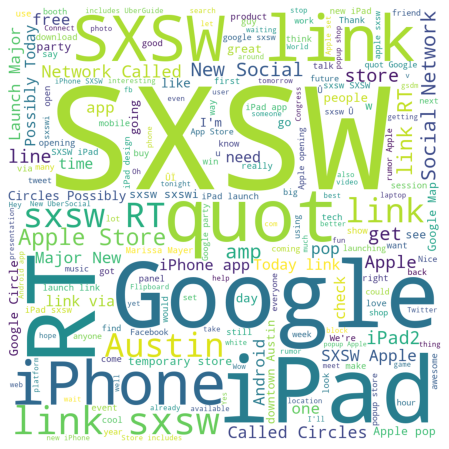

In [9]:
#importing the stopwords list to pass onto the WC generator
stopwords_list = stopwords.words('english')
stopwords_list.append('mention')

#droppping null values
df.dropna(inplace=True)

#instantiate
wc = WordCloud(background_color='white',
               stopwords=stopwords_list,
               height=1000,
               width=1000,
               )

#for the wordcloud, we have to join all the text data into a single string 
text = " ".join(df['tweet_text'])

#generate the WC
wc.generate(text)

#plot the WC
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(wc)
plt.show()

We can see from the above that the words `iPad,Google and SXSW` are tweeted the most, followed by `Austin and RT`. A google search of `SXSW` reveals it to be arts and music festival held in Austin,TX. We can reasonably conclude that tweets collected for the analysis coincided when the festival was running. 

# Analyzing emotions for each product_service

This is to answer the first question : What are the emotional repsonses for each product_service category listed in the data? For eg: for the category 'Apple' how many positive,negative and neutral responses are there?

By comparing the responses for each category, we can gage customer sentiment

In [10]:
#creating a pivot table to organize the data

df_pivot = df.pivot_table(index='product_service',aggfunc='count',columns='emotion')
df_pivot

tweet_text                   \
emotion            I can't tell Negative emotion   
product_service                                    
Android                     NaN             16.0   
Apple                       2.0             97.0   
Google                      2.0            115.0   
Not Applicable            147.0             51.0   
iPad                        4.0            125.0   
iPad or iPhone App          NaN             63.0   
iPhone                      1.0            103.0   

                                                                        
emotion            No emotion toward brand or product Positive emotion  
product_service                                                         
Android                                           2.0            141.0  
Apple                                            22.0            575.0  
Google                                           24.0            582.0  
Not Applicable                                 5297.0            306.0  
iPad                                             24.0            793.0  
iPad or iPhone App                               10.0            397.0  
iPhone                                            9.0            184.0

In [11]:
#renaming the columns
df_pivot.columns = ["I can't tell",'Negative emotion','No emotion toward brand or product', 'Positive emotion']
df_pivot

,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
product_service,,,,
Android,NaN,16.0,2.0,141.0
Apple,2.0,97.0,22.0,575.0
Google,2.0,115.0,24.0,582.0
Not Applicable,147.0,51.0,5297.0,306.0
iPad,4.0,125.0,24.0,793.0
iPad or iPhone App,NaN,63.0,10.0,397.0
iPhone,1.0,103.0,9.0,184.0


In [12]:
#dropping 'Not Applicable' since it is not relevant here
df_pivot.drop('Not Applicable',axis=0,inplace=True)

#rearranging the columns for better visualization
df_pivot=df_pivot[['Positive emotion','Negative emotion', 'No emotion toward brand or product', "I can't tell"]]

#sorting the values for better visuzalization
df_pivot.sort_values('Positive emotion',ascending=False,inplace=True)

df_pivot

,Positive emotion,Negative emotion,No emotion toward brand or product,I can't tell
product_service,,,,
iPad,793.0,125.0,24.0,4.0
Google,582.0,115.0,24.0,2.0
Apple,575.0,97.0,22.0,2.0
iPad or iPhone App,397.0,63.0,10.0,NaN
iPhone,184.0,103.0,9.0,1.0
Android,141.0,16.0,2.0,NaN


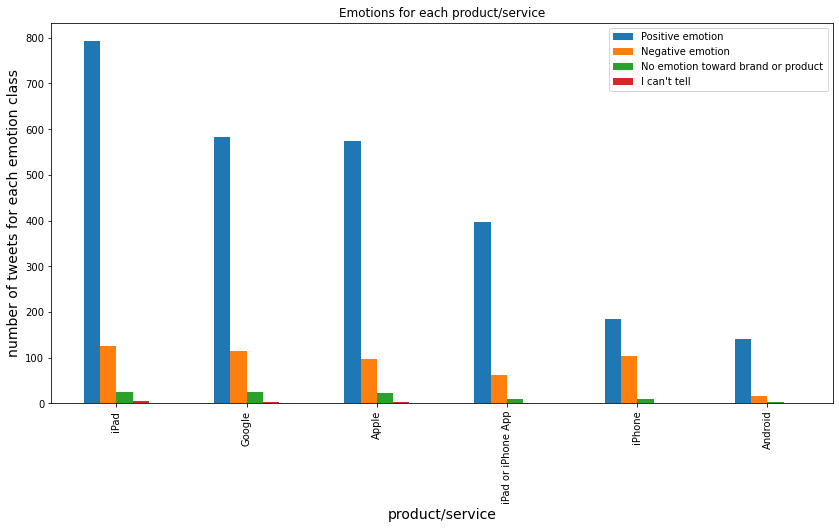

In [13]:
# bar chart listing emotion class for each product_service 

df_pivot.plot(kind='bar',figsize=(14,7));
plt.title('Emotions for each product/service');
plt.ylabel('number of tweets for each emotion class',fontsize=14);
plt.xlabel('product/service',fontsize=14);

# What do customers like about a product_service?

Here, we are looking to answer the second question.We can do this by breaking down each product_service and the different emotions to see if there are any key words that stand out. For eg: we can list out tweets by positive and negative emotions for iPad and analyze separately to gage sentiment.

Let's define some functions to make things easier

In [14]:
#creating a df for a product_service with positive emotions

def positive_df(df, product_service, emotion):
        product_df = df[df['product_service']==product_service]
        positive = product_df[product_df['emotion']==emotion]
        positive.dropna(inplace=True)
        return positive

In [15]:
#creating a df for a product_service with negative emotions

def negative_df(df, product_service, emotion):
        product_df = df[df['product_service']==product_service]
        negative = product_df[product_df['emotion']==emotion]
        negative.dropna(inplace=True)
        return negative

## Wordcloud for positive and negative emotions of Ipad

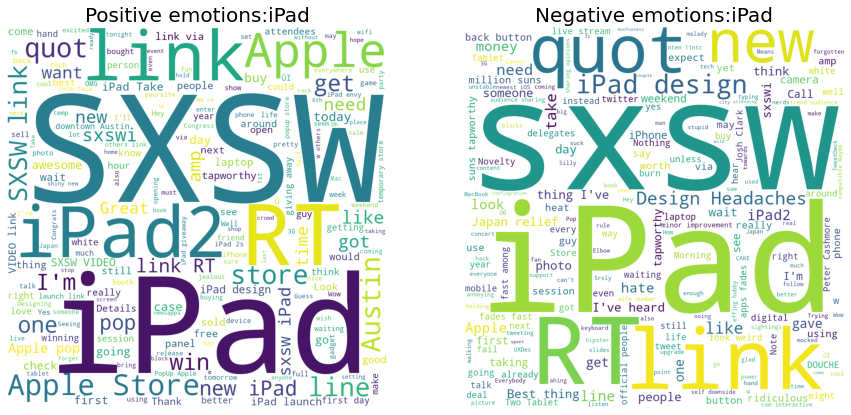

In [16]:
#creating positive and negative slices of the df

pos_df = positive_df(df,'iPad','Positive emotion')
neg_df = negative_df(df,'iPad','Negative emotion')

# generate the wordcloud
product = 'iPad'
wordcloud=[]
for df in [pos_df, neg_df]:
    #instantiate
    wc = WordCloud(background_color='white',
                       stopwords=stopwords_list,
                       height=1000,
                       width=1000,
                       )
    #for the wordcloud, we have to join all the text data into a single string 
    text = " ".join(df['tweet_text'])
    #generate the WC
    wordcloud.append(wc.generate(text))
#plot the WC
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
font = {'fontsize':20}
ax1.imshow(wordcloud[0])
ax1.axis('off')
ax1.set_title(f'Positive emotions:{product}',fontdict=font);
ax2.imshow(wordcloud[1])
ax2.axis('off')
ax2.set_title(f'Negative emotions:{product}',fontdict=font);

## Wordcloud for positive and negative emotions of Google

In [18]:
pos_df

,tweet_text,product_service,emotion


In [19]:
neg_df

,tweet_text,product_service,emotion


In [21]:
#creating positive and negative slices of the df

pos_df = positive_df(df,'iPhone','Positive emotion')
neg_df = negative_df(df,'iPhone','Negative emotion')

# generate the wordcloud
product = 'iPhone'
wordcloud=[]
for df in [pos_df, neg_df]:
    #instantiate
    wc = WordCloud(background_color='white',
                       stopwords=stopwords_list,
                       height=1000,
                       width=1000,
                       )
    #for the wordcloud, we have to join all the text data into a single string 
    text = " ".join(df['tweet_text'])
    #generate the WC
    wordcloud.append(wc.generate(text))
#plot the WC
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
font = {'fontsize':20}
ax1.imshow(wordcloud[0])
ax1.axis('off')
ax1.set_title(f'Positive emotions:{product}',fontdict=font);
ax2.imshow(wordcloud[1])
ax2.axis('off')
ax2.set_title(f'Negative emotions:{product}',fontdict=font);

ValueError: We need at least 1 word to plot a word cloud, got 0.

# Model to predict product_service from tweets

If there is a tweet, you want to be able to tell what product_service the tweet is referring to

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_text       0 non-null      object
 1   product_service  0 non-null      object
 2   emotion          0 non-null      object
dtypes: object(3)
memory usage: 0.0+ bytes


In [23]:
df['product_service'].value_counts()

Series([], Name: product_service, dtype: int64)

In [24]:
df['emotion'].value_counts()

Series([], Name: emotion, dtype: int64)

In [ ]:
# creating target values for product_service
new_map = {'iPad':1,
            'Google':2,
          'Apple':3,
          'iPad or iPhone App':4,
          'iPhone':5,
          'Android':6,
          'Not Applicable':0}

df['target'] = df['product_service'].map(new_map)
df.head()

## Building baseline models using CountVectorizer

In [ ]:
#setting up X,y train and test sets
X= df['tweet_text']
y = df['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=123)

#use the default pattern in sklearn for tokenizing
basic_token_pattern = r"(?u)\b\w\w+\b"

In [ ]:
# building a pipeline of LogisticRegression, Naive-Bayes, SVM and RandomForest models

# instantiate all the models

pipe_lr = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,token_pattern=basic_token_pattern)),
                    ('model',LogisticRegression(random_state=123))
                   ])

pipe_nb = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,token_pattern=basic_token_pattern)),
                    ('model',MultinomialNB())
                    ])

pipe_rf = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,token_pattern=basic_token_pattern)),
                    ('model',RandomForestClassifier(random_state=123))
                    ])

pipe_svm = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,token_pattern=basic_token_pattern)),
                    ('model',svm.SVC(random_state=123))
                    ])

#setting up names for the classification report
names_dict = dict(df['product_service'].value_counts())
names = [name for name in names_dict]

#build a list of tuples to build a df
models=['LogReg', 'MultiNB', 'RForest', 'SVM']
f1 = []

#fitting the models on the train sets
pipelines = [pipe_lr,pipe_nb,pipe_rf,pipe_svm]

for pipe in pipelines:
    pipe.fit(X_train,y_train)
    predictions = pipe.predict((X_test))
#     print(pipe)
#     print(classification_report(y_test,predictions,target_names=names))
    f1.append(f1_score(y_test,predictions,average='macro'))
    
#building a df of the f1_scores
scores = list(zip(models,f1))
scores_df = pd.DataFrame(data=scores,columns=['model','f1_score_cv'])

## Building baseline models using Tf-idf Vectorizer

In [ ]:
# repeating the same processes as above
pipe_lr = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,token_pattern=basic_token_pattern)),
                    ('model',LogisticRegression(random_state=123))
                   ])

pipe_nb = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,token_pattern=basic_token_pattern)),
                    ('model',MultinomialNB())
                    ])

pipe_rf = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,token_pattern=basic_token_pattern)),
                    ('model',RandomForestClassifier(random_state=123))
                    ])

pipe_svm = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,token_pattern=basic_token_pattern)),
                    ('model',svm.SVC(random_state=123))
                    ])

#setting up names for the classification report
names_dict = dict(df['product_service'].value_counts())
names = [name for name in names_dict]

#build a list of tuples to build a df
models=['LogReg', 'MultiNB', 'RForest', 'SVM']
f1 = []

#fitting the models on the train sets
pipelines = [pipe_lr,pipe_nb,pipe_rf,pipe_svm]

for pipe in pipelines:
    pipe.fit(X_train,y_train)
    predictions = pipe.predict((X_test))
#     print(pipe)
#     print(classification_report(y_test,predictions,target_names=names))
    f1.append(f1_score(y_test,predictions,average='macro'))
    
#adding the tf f1-scores to the scores_df
scores_df['f1_score_tf'] = f1

In [ ]:
#visualizing the f1-scores of all the models for the two vectorizers

fig,ax = plt.subplots(figsize=(10,7))
scores_df.plot(kind='bar',ax=ax);
ax.set_xticklabels(models,rotation=45);
ax.set_title('f1-scores');


Since the LogisticRegression model with the CountVectorizer has the highest f1-score among all models, let's use that for optimizations

# LogisticRegression with Countvectorizer

Let's get some more information of model performance

In [ ]:
lr_pipe = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,token_pattern=basic_token_pattern)),
                    ('model',LogisticRegression(random_state=123))
                   ])

lr_pipe.fit(X_train,y_train)
predictions=lr_pipe.predict(X_test)
print(classification_report(y_test,predictions,target_names=names))
fig,ax=plt.subplots(figsize=(10,10))
plot_confusion_matrix(lr_pipe,X_test,y_test,display_labels=names,ax=ax,xticks_rotation='vertical');

In [ ]:
# # setting a range for min_df and max_df
# min_df = np.arange(2,7,1) # words than appear less than the min_df value in all docs will be eliminated
# max_df = np.arange(50,57,1) # words than appear more than the max_df value in all docs will be eliminated

# #initiating lists to use for plotting
# f_score = []
# min_value=[]
# max_value=[]

# #setting up the loop for min_df and max_df values
# for i in min_df:
#     for j in max_df:
#         min_value.append(i)
#         max_value.append(j)
        
#         #instantiate pipeline
#         pipe_lr = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,token_pattern=basic_token_pattern)),
#                     ('model',LogisticRegression(random_state=123))
#                    ])
#         pipe_lr.fit(X_train,y_train)
#         preds = pipe_lr.predict(X_test)
        
#         #getting f1 score
#         score = f1_score(y_test,preds,average='macro')
#         f_score.append(score)
#         print(f'min_df = {i}, max_df = {j}, f1_score={score}')

# #visualizing the accuracy score for the different combinations
# d = list(zip(min_value,max_value))
# fig,ax=plt.subplots(figsize=(15,5))
# ax.plot(f_score,marker='o',markerfacecolor='r',ls='--');
# # ax.set_xticklabels(d);
# ax.set_title('F1 Score of the Logistic Regression Model with CountVectorizer');